# Package Load

In [1]:
import gc
import os
import re
import glob
import json
#import wandb
import random
import zipfile
import datetime
#import Levenshtein
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from typing import Dict, List, Optional, Tuple

import warnings
warnings.filterwarnings('ignore')

import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from torchinfo import summary
from torch.utils.data import Dataset, DataLoader

import torchaudio.transforms as tat
from torchaudio.models.decoder import cuda_ctc_decoder

import sys
sys.path.append('/jet/home/bermudez/exploring-eeg')
from data_extraction.dataset_builder import build_trial_index, split_by_session
from data_extraction.dataloader import make_dataloaders
from models.eeg_classifier import EEGClassifierBaseline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

/jet/home/bermudez/.conda/envs/eeg_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device:  cuda


In [2]:
config={
    'batch_size':128
}

In [3]:
root = "/ocean/projects/cis250019p/gandotra/11785-gp-eeg/ds005589"

from pathlib import Path

# 1. Build index from the known dataset root
index_df = build_trial_index(Path(root))



✅ Indexed 26000 EEG trials from 519 runs.


In [4]:
# 2. Split sessions
index_df = split_by_session(index_df)

# 3. Create DataLoaders
loaders = make_dataloaders(index_df, batch_size=config['batch_size'])

# 4. Inspect one batch
x_batch, y_batch = next(iter(loaders["train"]))
print("x_batch shape:", x_batch.shape)
print("First sample metadata:")
for k in y_batch.keys():
    print(f"  {k}: {y_batch[k][0]}")

split
train    15600
test      5200
val       5200
Name: count, dtype: int64
x_batch shape: torch.Size([128, 500, 122])
First sample metadata:
  subject: sub-28
  session: ses-02
  run: run-02
  image_name: C:\Users\Huawei\Desktop\eeg_pascal_imagenet\pic_10000_resized\boat\n03095699_15496_resized.jpg


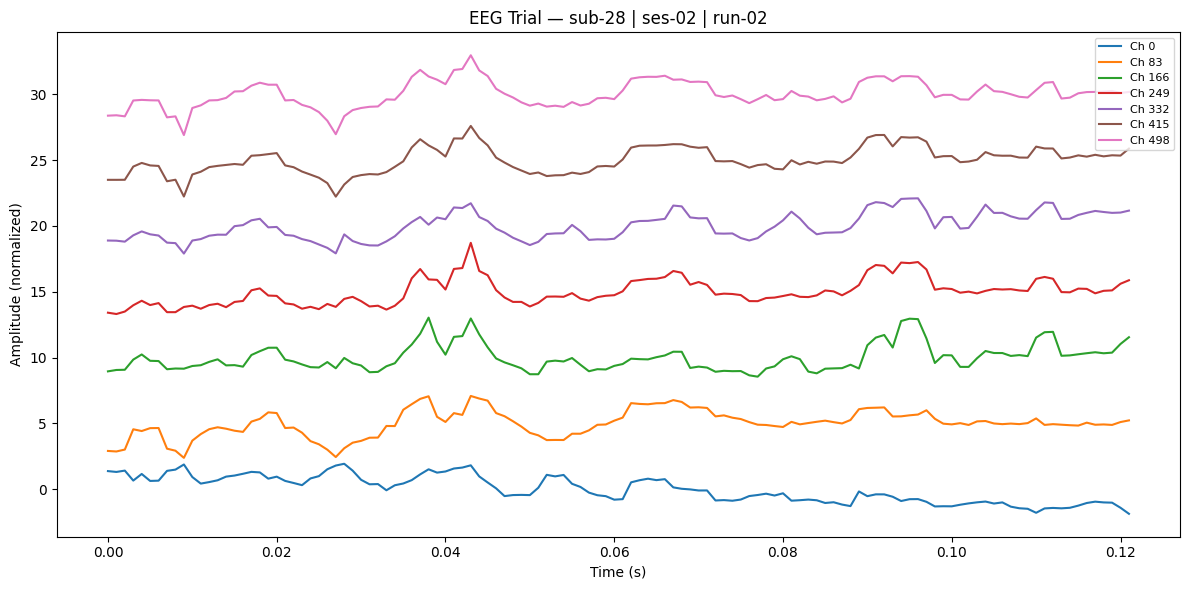

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_eeg_trial(x, title="EEG Trial", n_channels_to_plot=6):
    """
    Plot a subset of EEG channels from a single trial.

    Args:
        x (np.ndarray): EEG data [channels, time]
        title (str): Plot title
        n_channels_to_plot (int): Number of channels to visualize
    """
    plt.figure(figsize=(12, 6))
    num_channels, num_timepoints = x.shape
    time = np.arange(num_timepoints) / 1000.0  # assume 1000 Hz sampling
    step = max(1, num_channels // n_channels_to_plot)

    for i, ch in enumerate(range(0, num_channels, step)):
        plt.plot(time, x[ch] + i * 5, label=f"Ch {ch}")

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (normalized)")
    plt.legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    plt.show()


# ===============================
# TEST CELL: Visualize one EEG trial
# ===============================

if root is None:
    # Create synthetic EEG for testing
    C, T = 122, 500
    rng = np.random.default_rng(42)
    x = rng.normal(0, 1, (C, T))
    for ch in range(90, 110):
        x[ch, 180:230] += np.hanning(50) * 3.0  # Add simulated ERP bump
    # Channel-wise z-score normalization
    x = (x - x.mean(axis=1, keepdims=True)) / (x.std(axis=1, keepdims=True) + 1e-6)
    plot_eeg_trial(x, "Synthetic EEG Trial (Demo)")
else:
    # Load one EEG trial from training DataLoader
    x_batch, y_batch = next(iter(loaders["train"]))
    x_trial = x_batch[0].numpy()

    # Handle dictionary-style y_batch
    subj = y_batch["subject"][0]
    ses = y_batch["session"][0]
    run = y_batch["run"][0]

    plot_eeg_trial(x_trial, f"EEG Trial — {subj} | {ses} | {run}")

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm



# --- Configuration ---
num_classes = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EEGClassifierBaseline(num_channels=122, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# --- Training loop ---
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for x_batch, y_batch in tqdm(loaders["train"], desc=f"Epoch {epoch+1}/{num_epochs}"):
        x_batch = x_batch.to(device)                 # [B, 122, 500]
        labels = torch.tensor(
            [int(img_name.split("_")[0]) % num_classes for img_name in y_batch["image_name"]]
        ).to(device)                                # placeholder mapping if labels are not pre-encoded

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_batch.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += x_batch.size(0)

    acc = train_correct / train_total
    print(f"Epoch {epoch+1}: Loss={train_loss/train_total:.4f} | Acc={acc*100:.2f}%")

Epoch 1/10:   0%|                                                             | 0/122 [00:07<?, ?it/s]


ValueError: invalid literal for int() with base 10: 'C:\\Users\\casia\\Desktop\\eeg'